# Make your own Ordinary Kriging object

In [1]:
## Common analysis packages
import numpy as NP
import matplotlib.pyplot as PLT
from tqdm import tqdm as TQDM

## scipy packages
import scipy.linalg
from scipy import optimize as OPT
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist

## geometry packages
import geopandas as GPD
import rasterio as RAST
from rasterio.transform import from_origin
from shapely.geometry import Point

## Load variogram object
from variogram import variogram as VARIOGRAM

## 1. Define Ordinary Kriging object

In [2]:
class ordinarykriging(object):
    def __init__(self, varigoram, debug=False):
        ## Local parameters ##
        self.variogram = varigoram
        self.debug = debug

    def fit(self, X, y):
        return fit(self, X, y)

    def predict(self, X, n_neighbor=None, radius=NP.inf, use_nugget=False):
        return predict(self, X, n_neighbor=n_neighbor, radius=radius, use_nugget=use_nugget)

## 2. Load rive muese data & split to train and test data

In [3]:
gdf = GPD.read_file('./data/muese.shp')
gdf.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,x,y,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,181072.0,333611.0,POINT (5.758536241675762 50.99156215667816)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,181025.0,333558.0,POINT (5.757863018200728 50.99108790288359)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,181165.0,333537.0,POINT (5.759855417830628 50.99089274333686)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,181298.0,333484.0,POINT (5.761745770023087 50.99041023559325)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,181307.0,333330.0,POINT (5.761862707698853 50.98902557091748)


In [4]:
NP.random.seed(0)
test_idxes = NP.random.choice(a=gdf.index, size=int(NP.round(len(gdf)/4)))
train_idxes = NP.array(list(set(gdf.index).difference(set(test_idxes))))
meuse_test = gdf.loc[test_idxes,:].copy()
meuse_train = gdf.loc[train_idxes,:].copy()
print(len(meuse_train), len(meuse_test), len(gdf))

122 39 155


## 3. Create variogram object with input 'x', 'y' and 'lead' (step 1)

<Figure size 720x432 with 0 Axes>

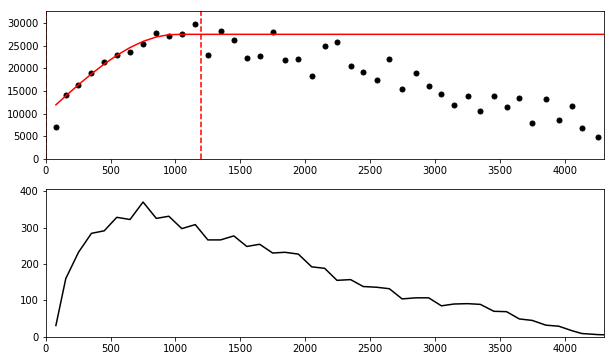

In [5]:
## model
def variogram_spherical(d, pars):
    """Spherical model, pars[3] = [psill, range, nugget]
                             3 * d           d^3  
    x <= [2] : y = [0] * ( ---------  -  ---------- ) + [2]
                            2 * [1]       2 * [1]^3
    x > [2]  : y = [0] + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return NP.piecewise( d, 
                        [d <= prange, d > prange],
                        [lambda x: psill * ((3.*x)/(2.*prange) - (x**3.)/(2.*prange**3.)) + pnugget, 
                         psill + pnugget])
## train variogram
var_muese = VARIOGRAM(100, model=variogram_spherical)
var_muese.fit(meuse_train[['x', 'y']], meuse_train['lead'], fit_range=[0,1200])
PLT.figure(figsize=[10,6])
var_muese.plot()
## upper plot : semi-varogram, down-plot : statistics

## 4. Create ordinary kriging object with input variogram (step 2)

In [6]:
ok_muese = ordinarykriging(var_muese)

## 5. Load measurements with k-Tree
The data structure of ***k-Tree*** is used to record sptial information for speed up searching neighbors. In general, you can create and fit varigoram in fit function.

In [7]:
def fit(self, X, y):
    """
   [DESCRIPTION]
       Store the data with KDTree or original data structure, and fit the variogram model with set parameters.
   [INPUT]
       X    : array-like, input data with features, same data size with y.
       y    : array-like, input data with interesting value, same data size with X
   [OUTPUT]
       Null
    """
    X = NP.atleast_1d(X)
    y = NP.atleast_1d(y)
    self.shape = X.shape
    self.ndim = X.ndim
    self.y = y
    self.X = cKDTree(X, copy_data=True)

In [8]:
ok_muese.fit(meuse_train[['x', 'y']], meuse_train['lead'])

## 5. Prediction calculation (step 2)
The ordinary kriging interpolation is defined

$$
\hat{z}(\mathbf{s}_k) = \sum_{i\in n_k}w_iz(\mathbf{s}_i)
$$

where the weights $w_i$ can be optimized with ***BLUP*** to

$$
\begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n \\
\lambda
\end{bmatrix}
=
\begin{bmatrix}
V_{11} & V_{12} & \cdots & V_{1n} & -1 \\
V_{21} & V_{22} &\cdots & V_{2n} & -1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
V_{n1} & V_{n2} & \cdots & V_{nn} & -1 \\
1 & 1 & \cdots & 1 & 0 
\end{bmatrix}^{-1}
\begin{bmatrix}
V_{k1} \\
V_{k2} \\
\vdots \\
V_{kn} \\
1
\end{bmatrix}
$$

Evaluate the precision with train and test data.

In [9]:
def predict(self, X, n_neighbor=None, radius=NP.inf, use_nugget=False):
    '''
    [DESCRIPTION]
       Calculate and predict interesting value with looping for all data, the method take long time but save memory
       Obtain the linear argibra terms
        | V_ij -1 || w_i | = | V_k |
        |  1   0 ||  u  |   |  1  |
            a    *   w    =    b
          w = a^-1 * b
          y = w_i * Y
        V_ij : semi-variance matrix within n neighors
        V_k  : semi-variance vector between interesting point and n neighbors
        w_i  : weights for linear combination
        u    : lagrainge multiplier
        Y    : true value of neighbors
        y    : predicted value of interesting point
    [INPUT]
        X          : array-like, input data with same number of fearture in training data
        n_neighbor : int,        number of neighbor w.r.t input data, while distance < searching radius (5)
        radius     : float,      searching radius w.r.t input data (inf)
        use_nugget : bool,       if use nugget to be diagonal of kriging matrix for prediction calculation (False)
    [OUTPUT]
        1D/2D array(float)
        prediction : float, prdicted value via Kriging system y
        error      : float, error of predicted value (only if get_error = True)
        lambda     : float, lagrange multiplier u
    '''
    ## Make input to numpy.array
    X = NP.atleast_1d(X)
    if self.ndim == 1:
        if X.ndim < 2: X = X[:, NP.newaxis]
    else:
        X = NP.atleast_2d(X)

    ## Find the neighbors with K-tree object
    if n_neighbor is None:
        n_neighbor = self.shape[0]
    neighbor_dst, neighbor_idx = self.X.query(X, k=n_neighbor, p=2)

    ## Calculate prediction
    idxes = range(X.shape[0])
    out_lambda = NP.zeros(len(X))
    out_predict = NP.zeros(len(X))
    out_error = NP.zeros(len(X))
    for nd, ni, i in zip(neighbor_dst, neighbor_idx, idxes):
        ## select in searching radius
        ni = ni[nd < radius] # neighbors' index, while the distance < search radius
        nd = nd[nd < radius] # neighbors' distance, while the distance < search radius

        if len(ni) == 0:
            continue
        else:
            n = len(ni)

        ## Initialization
        a = NP.zeros((n+1,n+1))
        b = NP.ones((n+1,))

        ## Fill matrix a
        a[:n, :n] = self.variogram.predict(cdist(self.X.data[ni], self.X.data[ni], metric='euclidean'))
        a[:n, n] = 1
        a[n, :n] = 1

        ## Fill vector b
        b[:n] = self.variogram.predict(nd)

        ## set self-varinace is zero if not using Nugget
        if not use_nugget:
            ## modify a
            NP.fill_diagonal(a, 0.)
            ## modify b
            zero_index = NP.where(NP.absolute(nd) == 0)
            if len(zero_index) > 0:
                b[zero_index[0]] = 0.

        ## Get weights
        #w = scipy.linalg.solve(a, b) # no constraint solution
        w = OPT.nnls(a, b)[0] # non-negative solution

        ## Fill results and prediction
        out_lambda[i] = w[n]
        out_predict[i] = w[:n].dot(self.y[ni])
        out_error[i] = NP.sqrt(w[:n].dot(b[:n]))

    return out_predict, out_error, out_lambda

In [10]:
meuse_train['lead_predict'] = ok_muese.predict(meuse_train[['x', 'y']])[0]
meuse_test['lead_predict'] = ok_muese.predict(meuse_test[['x', 'y']])[0]
meuse_train['residual'] = meuse_train['lead_predict'] - meuse_train['lead']
meuse_test['residual'] = meuse_test['lead_predict'] - meuse_test['lead']

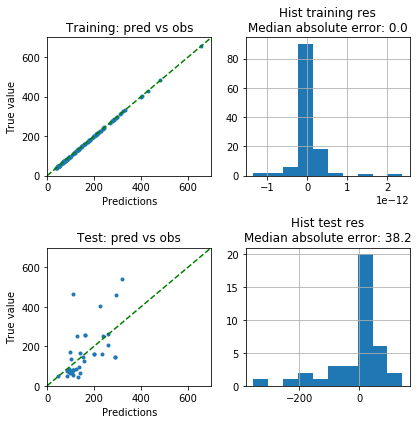

In [11]:
PLT.figure(figsize=(6,6))
PLT.subplot(221)
PLT.plot(meuse_train['lead_predict'], meuse_train['lead'], '.')
PLT.title('Training: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.plot([0,700], [0,700], 'g--')
PLT.ylim(0,700)
PLT.xlim(0,700)
PLT.subplot(222)
meuse_train['residual'].hist()
PLT.title('Hist training res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(meuse_train['residual']))))
PLT.subplot(223)
PLT.plot(meuse_test['lead_predict'], meuse_test['lead'], '.')
PLT.plot([0,700], [0,700], 'g--')
PLT.title('Test: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.ylim(0,700)
PLT.xlim(0,700)
PLT.subplot(224)
meuse_test['residual'].hist()
PLT.title('Hist test res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(meuse_test['residual']))))
PLT.tight_layout()

## 6. Generate raster data for visulization

### 6.1. Input all data for ordinary kriging

In [12]:
## step 1. varigoram
var_muese = VARIOGRAM(100, model=variogram_spherical)
var_muese.fit(gdf[['x', 'y']], gdf['lead'], fit_range=[0,1500])
## step 2. ordinary kriging system
ok_muese = ordinarykriging(var_muese)
ok_muese.fit(gdf[['x', 'y']], gdf['lead'])

### 6.2. Make grids in the interseted region

In [13]:
buffer = 1000 # [m]
cellsize = 50 # [m]
xmin = gdf['x'].min() - buffer
xmax = gdf['x'].max() + buffer
ymin = gdf['y'].min() - buffer
ymax = gdf['y'].max() + buffer
# * Create 2D extent and grid
## Grid is from top-left to bottom-right
X, Y = NP.meshgrid( NP.arange(xmin, xmax+cellsize, cellsize),
                    NP.arange(ymin, ymax+cellsize, cellsize))
## set prediction location is in the central of grid
xy = NP.concatenate(( X.flatten()[:, NP.newaxis] + cellsize/2,
                      Y.flatten()[:, NP.newaxis] - cellsize/2),
                      axis=1)

### 6.3. Interpolate to the grids

In [14]:
## Define variables
xbins = X.shape[1]
ybins = Y.shape[0]
transform = from_origin(X.min(), Y.max(), cellsize, cellsize) # Set raster left-top's coordinates

## Predict
print(">> Interpolating %d cells (%d, %d)...."%(len(xy), xbins, ybins))
lead_predict = ok_muese.predict(xy)
#lead_predict = ok_muese.predict(xy, radius=var_muese.range, n_neighbor=7)
#print(var_muese.range)

>> Interpolating 11543 cells (97, 119)....


### 6.4. Save to geotif file .tif with rasterio package

In [15]:
z = lead_predict[0]
raster = RAST.open('./data/meuse_prediction.tif', 
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=z.dtype,
                    crs='epsg:28992',
                    transform=transform )
raster.write(NP.flip(z.reshape(ybins,xbins), 0), 1)
raster.close()

In [16]:
error = lead_predict[1]
raster = RAST.open('./data/meuse_prediction_error.tif', 
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=error.dtype,
                    crs='epsg:28992',
                    transform=transform )
raster.write(NP.flip(error.reshape(ybins,xbins), 0), 1)
raster.close()